In [1]:
import os
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 64
lr = 0.001
epochs = 200
batch_size = 8
limit = 4096 # number of training examples to use.
alpha = 1.0 # penalise polysemantic neurons.

In [6]:
assert (limit % 8 == 0)

In [7]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-25 20:33:56.598496: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-25 20:33:56.611780: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe1e5c6a780 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-25 20:33:56.611795: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [8]:
def calculate_term(e, c0, c1):
    a = tf.gather(indices=c0, params=e) \
      / tf.tile(K.expand_dims(K.max(K.abs(tf.gather(indices=c0, params=e)), axis=1) + 1e-9), (1, e.shape[-1]))
    b = tf.gather(indices=c1, params=e) \
      / tf.tile(K.expand_dims(K.max(K.abs(tf.gather(indices=c1, params=e)), axis=1) + 1e-9), (1, e.shape[-1]))
    return K.sum(a*b, axis=1)

In [9]:
def my_loss(y_true, y_pred, e, c0, c1, alpha):
    p_loss = (1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e, c0, c1)
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (K.sum(p_loss) / len(c0))
    return loss

### precalculate all indices for batch_size choose 2 pairs

In [10]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [11]:
print(len(c0))

28


In [12]:
model.add_loss(my_loss(i2, o, e, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [13]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

def cce(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true=y_true, y_pred=y_pred)

def ps_term(y_true, e, c0, c1):
    p_loss = (1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e, c0, c1)
    return tf.convert_to_tensor(p_loss)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')
model.add_metric(cce(i2, o), name='cce', aggregation='mean')
model.add_metric(ps_term(i2, e, c0, c1), name='ps', aggregation='mean')

In [14]:
history = model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
                    y=None,
                    validation_data=([np.array(x_train_reshape)[limit:limit+80], 
                                     y_train[limit:limit+80]], None),
                    batch_size=batch_size,
                    epochs=epochs)

Train on 4096 samples, validate on 80 samples
Epoch 1/200
4096/4096 [==============================] - 3s 744us/sample - loss: 1.7121 - acc: 0.9232 - cce: 1.4858 - ps: 0.2263 - val_loss: 0.9924 - val_acc: 0.9575 - val_cce: 0.7461 - val_ps: 0.2463
Epoch 2/200
4096/4096 [==============================] - 2s 471us/sample - loss: 0.6384 - acc: 0.9751 - cce: 0.4489 - ps: 0.1894 - val_loss: 0.5750 - val_acc: 0.9787 - val_cce: 0.4196 - val_ps: 0.1553
Epoch 3/200
4096/4096 [==============================] - 2s 477us/sample - loss: 0.4066 - acc: 0.9855 - cce: 0.2752 - ps: 0.1314 - val_loss: 0.4689 - val_acc: 0.9800 - val_cce: 0.3571 - val_ps: 0.1118
Epoch 4/200
4096/4096 [==============================] - 2s 474us/sample - loss: 0.3066 - acc: 0.9887 - cce: 0.2065 - ps: 0.1002 - val_loss: 0.4026 - val_acc: 0.9812 - val_cce: 0.3023 - val_ps: 0.1003
Epoch 5/200
4096/4096 [==============================] - 2s 472us/sample - loss: 0.2397 - acc: 0.9918 - cce: 0.1554 - ps: 0.0843 - val_loss: 0.3479 - 

4096/4096 [==============================] - 2s 466us/sample - loss: 0.0065 - acc: 0.9999 - cce: 0.0028 - ps: 0.0037 - val_loss: 0.3310 - val_acc: 0.9837 - val_cce: 0.3233 - val_ps: 0.0077
Epoch 42/200
4096/4096 [==============================] - 2s 469us/sample - loss: 0.0050 - acc: 1.0000 - cce: 0.0018 - ps: 0.0032 - val_loss: 0.3466 - val_acc: 0.9850 - val_cce: 0.3353 - val_ps: 0.0113
Epoch 43/200
4096/4096 [==============================] - 2s 461us/sample - loss: 0.0054 - acc: 0.9999 - cce: 0.0026 - ps: 0.0028 - val_loss: 0.3576 - val_acc: 0.9862 - val_cce: 0.3468 - val_ps: 0.0107
Epoch 44/200
4096/4096 [==============================] - 2s 461us/sample - loss: 0.0054 - acc: 1.0000 - cce: 0.0019 - ps: 0.0035 - val_loss: 0.3755 - val_acc: 0.9825 - val_cce: 0.3665 - val_ps: 0.0090
Epoch 45/200
4096/4096 [==============================] - 2s 475us/sample - loss: 0.0042 - acc: 1.0000 - cce: 0.0018 - ps: 0.0024 - val_loss: 0.3665 - val_acc: 0.9862 - val_cce: 0.3584 - val_ps: 0.0081
Epo

Epoch 81/200
4096/4096 [==============================] - 2s 475us/sample - loss: 0.0013 - acc: 1.0000 - cce: 4.3831e-04 - ps: 9.0306e-04 - val_loss: 0.5677 - val_acc: 0.9825 - val_cce: 0.5586 - val_ps: 0.0090
Epoch 82/200
4096/4096 [==============================] - 2s 510us/sample - loss: 0.0012 - acc: 1.0000 - cce: 3.9660e-04 - ps: 8.1133e-04 - val_loss: 0.5034 - val_acc: 0.9800 - val_cce: 0.4936 - val_ps: 0.0097
Epoch 83/200
4096/4096 [==============================] - 2s 493us/sample - loss: 7.2289e-04 - acc: 1.0000 - cce: 3.7569e-04 - ps: 3.4721e-04 - val_loss: 0.5795 - val_acc: 0.9800 - val_cce: 0.5698 - val_ps: 0.0097
Epoch 84/200
4096/4096 [==============================] - 2s 480us/sample - loss: 8.8645e-04 - acc: 1.0000 - cce: 3.4996e-04 - ps: 5.3649e-04 - val_loss: 0.5870 - val_acc: 0.9800 - val_cce: 0.5792 - val_ps: 0.0078
Epoch 85/200
4096/4096 [==============================] - 2s 476us/sample - loss: 0.0021 - acc: 0.9999 - cce: 0.0013 - ps: 7.8608e-04 - val_loss: 0.4829

4096/4096 [==============================] - 2s 490us/sample - loss: 5.8782e-04 - acc: 1.0000 - cce: 1.7806e-04 - ps: 4.0976e-04 - val_loss: 0.8313 - val_acc: 0.9825 - val_cce: 0.8239 - val_ps: 0.0075
Epoch 120/200
4096/4096 [==============================] - 2s 476us/sample - loss: 7.6268e-04 - acc: 1.0000 - cce: 1.9342e-04 - ps: 5.6926e-04 - val_loss: 0.5780 - val_acc: 0.9825 - val_cce: 0.5742 - val_ps: 0.0039
Epoch 121/200
4096/4096 [==============================] - 2s 502us/sample - loss: 4.5043e-04 - acc: 1.0000 - cce: 1.7084e-04 - ps: 2.7959e-04 - val_loss: 0.5583 - val_acc: 0.9825 - val_cce: 0.5559 - val_ps: 0.0024
Epoch 122/200
4096/4096 [==============================] - 2s 507us/sample - loss: 4.3148e-04 - acc: 1.0000 - cce: 1.6591e-04 - ps: 2.6558e-04 - val_loss: 0.7259 - val_acc: 0.9812 - val_cce: 0.7228 - val_ps: 0.0031
Epoch 123/200
4096/4096 [==============================] - 2s 505us/sample - loss: 8.1443e-04 - acc: 1.0000 - cce: 3.1653e-04 - ps: 4.9790e-04 - val_loss:

4096/4096 [==============================] - 2s 495us/sample - loss: 1.1249e-04 - acc: 1.0000 - cce: 5.1409e-05 - ps: 6.1086e-05 - val_loss: 0.8450 - val_acc: 0.9750 - val_cce: 0.8418 - val_ps: 0.0032
Epoch 158/200
4096/4096 [==============================] - 2s 491us/sample - loss: 6.2324e-04 - acc: 1.0000 - cce: 1.2126e-04 - ps: 5.0199e-04 - val_loss: 0.8109 - val_acc: 0.9800 - val_cce: 0.8082 - val_ps: 0.0027
Epoch 159/200
4096/4096 [==============================] - 2s 489us/sample - loss: 4.5664e-04 - acc: 1.0000 - cce: 2.0455e-04 - ps: 2.5209e-04 - val_loss: 0.7410 - val_acc: 0.9825 - val_cce: 0.7385 - val_ps: 0.0025
Epoch 160/200
4096/4096 [==============================] - 2s 502us/sample - loss: 4.8598e-04 - acc: 1.0000 - cce: 1.2114e-04 - ps: 3.6485e-04 - val_loss: 0.6395 - val_acc: 0.9800 - val_cce: 0.6369 - val_ps: 0.0026
Epoch 161/200
4096/4096 [==============================] - 2s 492us/sample - loss: 0.0014 - acc: 0.9999 - cce: 0.0013 - ps: 8.0702e-05 - val_loss: 0.5666 

4096/4096 [==============================] - 2s 542us/sample - loss: 2.4319e-04 - acc: 1.0000 - cce: 1.1481e-04 - ps: 1.2838e-04 - val_loss: 0.8043 - val_acc: 0.9775 - val_cce: 0.8018 - val_ps: 0.0026
Epoch 196/200
4096/4096 [==============================] - 2s 533us/sample - loss: 2.1522e-04 - acc: 1.0000 - cce: 3.1252e-05 - ps: 1.8397e-04 - val_loss: 0.8475 - val_acc: 0.9750 - val_cce: 0.8427 - val_ps: 0.0048
Epoch 197/200
4096/4096 [==============================] - 2s 526us/sample - loss: 3.6674e-04 - acc: 1.0000 - cce: 1.3549e-04 - ps: 2.3125e-04 - val_loss: 0.7891 - val_acc: 0.9775 - val_cce: 0.7863 - val_ps: 0.0028
Epoch 198/200
4096/4096 [==============================] - 2s 538us/sample - loss: 0.0015 - acc: 1.0000 - cce: 0.0014 - ps: 1.3104e-04 - val_loss: 0.8166 - val_acc: 0.9775 - val_cce: 0.8141 - val_ps: 0.0025
Epoch 199/200
4096/4096 [==============================] - 2s 524us/sample - loss: 9.0771e-04 - acc: 1.0000 - cce: 7.3072e-04 - ps: 1.7699e-04 - val_loss: 0.9744 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


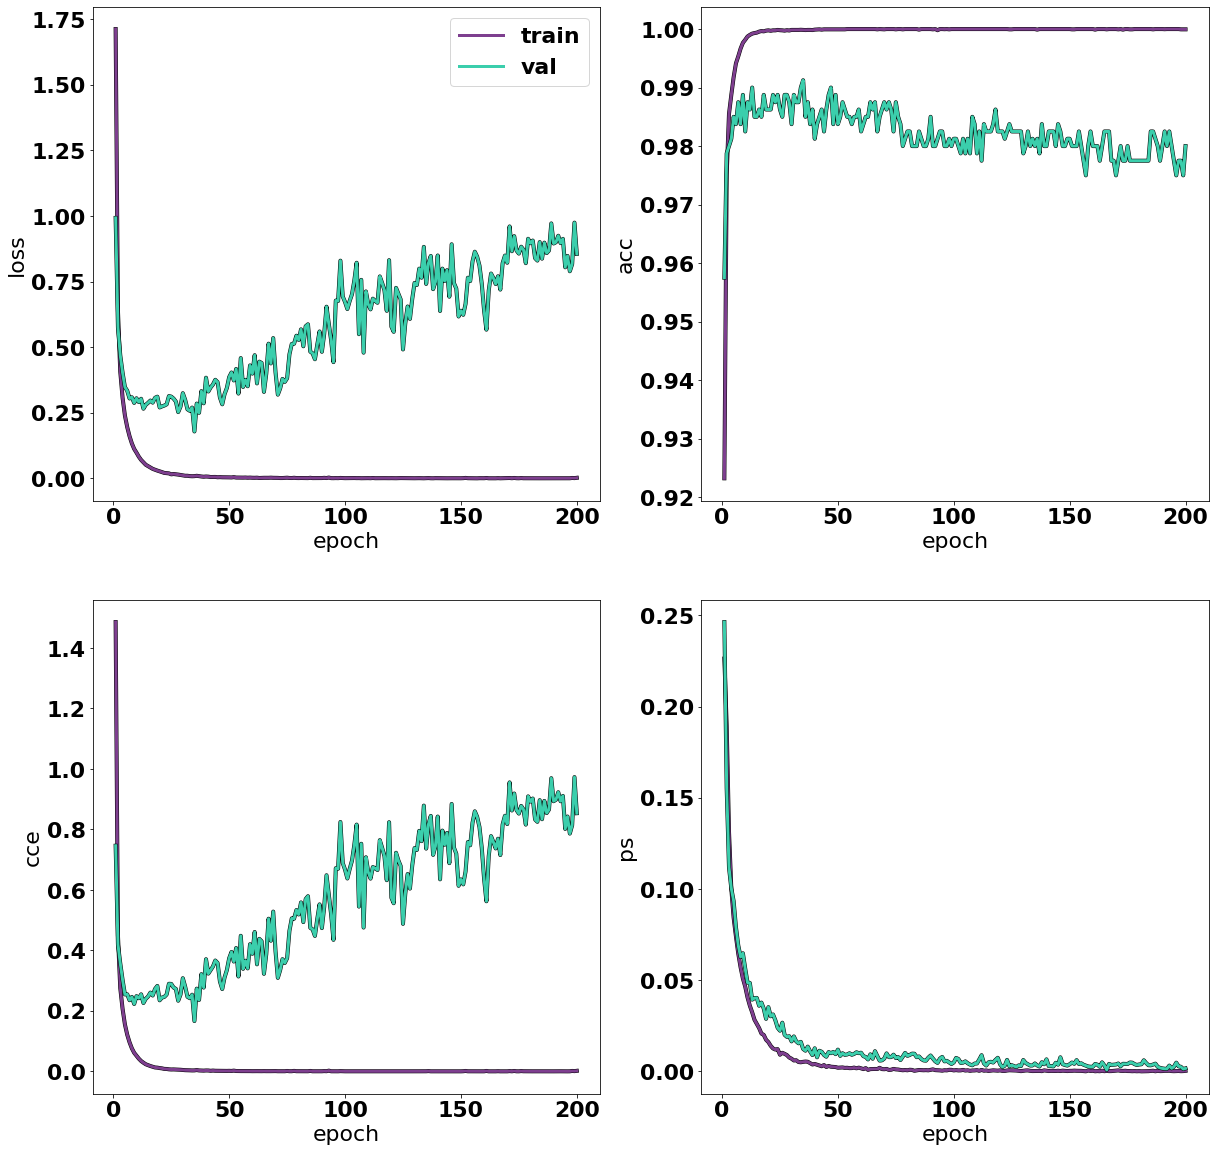

In [15]:
fig = plt.figure(figsize=(20,20))
for j,m in enumerate(['loss', 'acc', 'cce', 'ps']):
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), 'k-', lw=4)
    t, = ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), '-', color='#7E3F8F', lw=3)
    ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), 'k-', lw=4)
    v, = ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), '-', color='#3BCEAC', lw=3)
    ax.set_ylabel(m)
    ax.set_xlabel('epoch')
    if j == 0:
        ax.legend([t, v], ['train', 'val'])


### calculate test set accuracy

In [16]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test_reshape))
print(np.mean(my_acc(y_test, y_pred_test)))

0.98246


### calculate activations across the training set

In [17]:
embed = tf.keras.Model(inputs=i, outputs=e)

In [18]:
embed.layers[1].set_weights(model.layers[1].get_weights())
activations_by_class = {}
a = embed.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 907.53it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


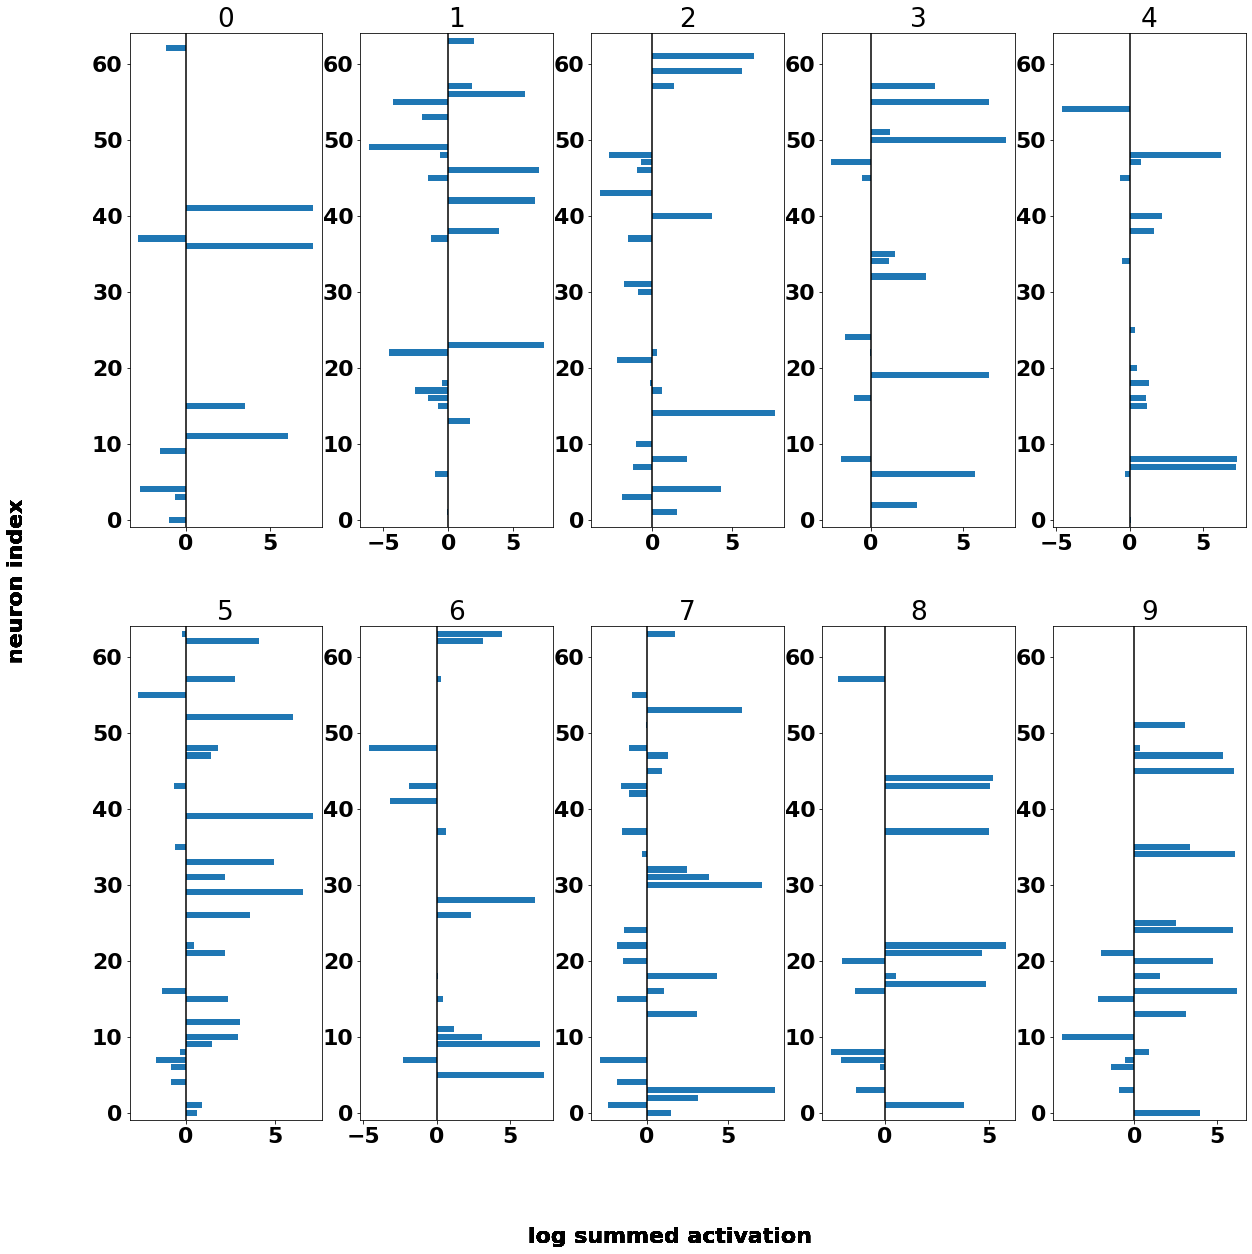

In [19]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### calculate activations across the test set

In [20]:
activations_by_class_test = {}
a = embed.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5543.78it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


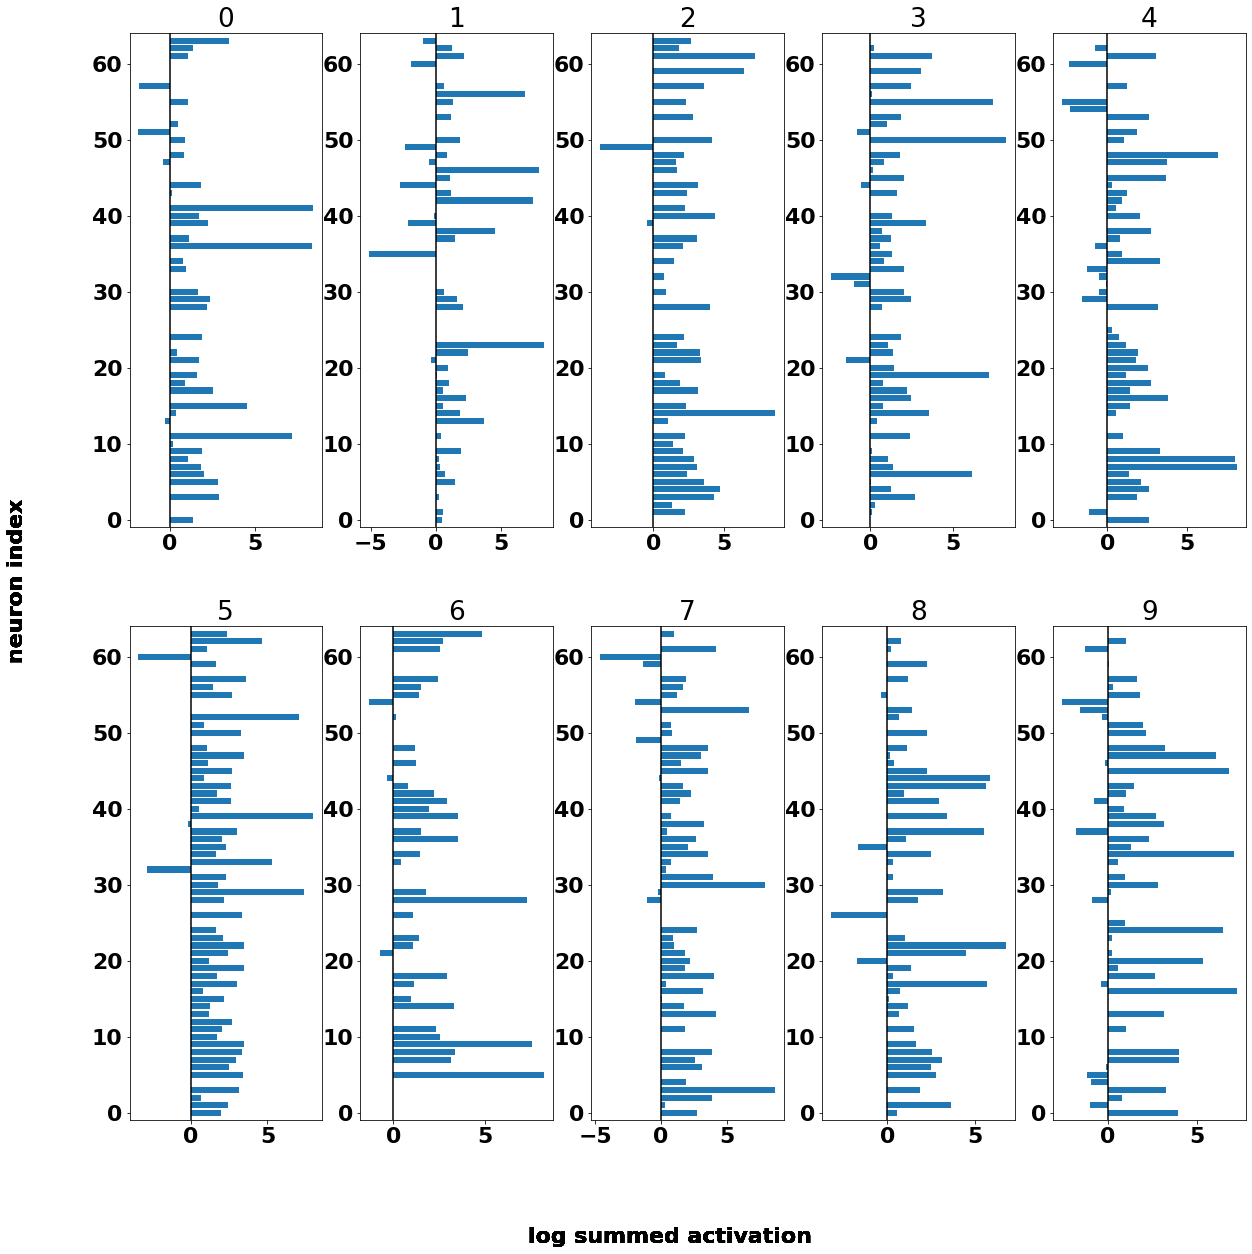

In [21]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class_test[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### measure degree of polysemantism across training set activations

In [22]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.0009681153020141053


### measure degree of polysemantism across test set activations

In [23]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.01629774060727666


### visualise hidden neurons

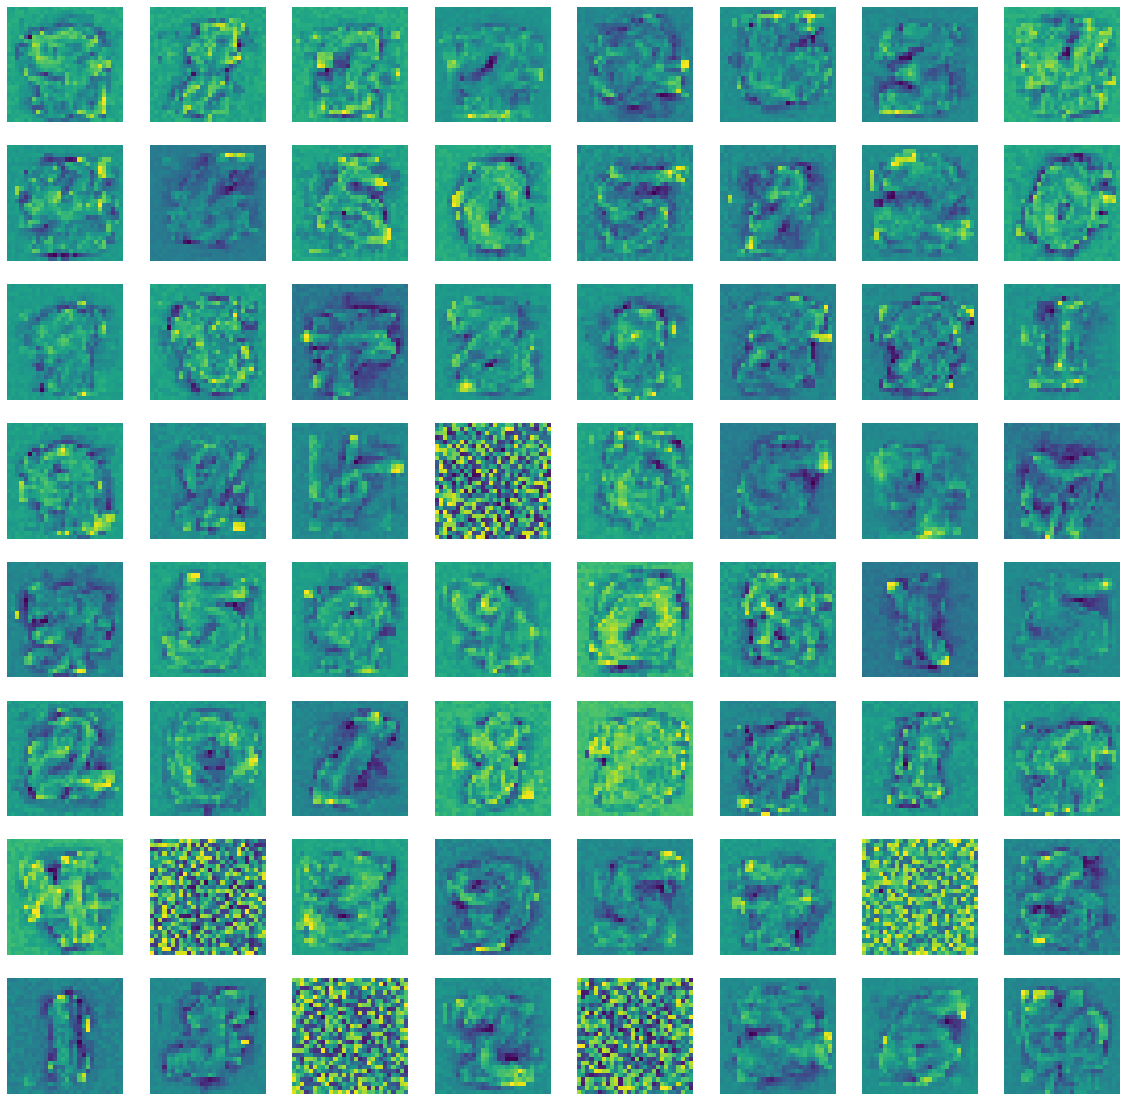

In [24]:
W = embed.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((28,28)))
    plt.axis('off')
plt.show()